In [1]:
%pip install dotwiz
%pip install seaborn
%cd ..
%pip install .

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
/home/code/Documents/poseidon_deeponet_iara


/opt/conda/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Defaulting to user installation because normal site-packages is not writeable
Processing /home/code/Documents/poseidon_deeponet_iara
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for poseidon: filename=poseidon-0.2.0-py3-none-any.whl size=19954 sha256=512d166da4d698cbe3f76c6a098070cd0c66815a73f89407de01c66e34b68963
  Stored in directory: /tmp/pip-ephem-wheel-cache-94f0zdqd/wheels/59/b4/05/2806b4fffe3ca70a611fe9dc60f0d270107aa0519b8a938654
Successfully built poseidon
  Attempting uninstall: poseidon
    Found existing installation: poseidon 0.2.0
    Uninstalling poseidon-0.2.0:
      Successfully uninstalled poseidon-0.2.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from dotwiz import DotWiz
from pathlib import Path

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

from poseidon.io.iara.offline import load_sonar_from_csv, Target, load_processed_data
from poseidon.dataset.dataset import SonarRunDataset, SonarRunPairDataset
from poseidon.model_selection import SonarCrossValidator
from poseidon.signal.passivesonar import lofar
from poseidon.signal.utils import resample

from poseidon.visualization import plot_lofargram
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [17]:
config =  {
    "dataset": {
        "name": "iara",
        "metadata_path": "../../../data/iara.csv",
        "raw_data_path" : "/home/iara/",
        "cache_path" : "./data/iara_cache"
    },
    # "window_size": 1,
    "window_size": 16,
    "overlap" : 0,
    "n_freqs": 512,
    "learning_rate": 0.001,
    "model_name": "MLP",
    "output_size": 4,
    "batch_size": 32,
    "hidden_size": 128,
    "n_splits": 5,
    "fold": 0,
    "epochs": 100,
    "patience": 10,
        "seed": 42
}
config = DotWiz(config)

In [16]:
%pwd
%ls /home/iara

A/  B/  C/  D/  E/  F/  G/  H/


In [18]:
csv_path = config.dataset.metadata_path
iara_data_root_path = config.dataset.raw_data_path
iara_raw = load_sonar_from_csv(csv_path, data_root_path=iara_data_root_path, target_column="Ship Length Class")

Reading dataset metadata from: ../../../data/iara.csv
Using data root path: /home/iara/
Grouping by target column: 'Ship Length Class'
Dataset structure loaded. Found 4 classes.
  - Class '0': 476 runs
  - Class '1': 400 runs
  - Class '2': 641 runs
  - Class '3': 308 runs


In [19]:
# iara_raw['0']['A-0002']['fs']

cache_dir = config.dataset.cache_path
Path(cache_dir).mkdir(parents=True, exist_ok=True)

def lofar_fn(x):
    signal = resample(x['signal'], x['fs'], 16000)
    fs = 16000
    # x is a dict with keys 'signal' and 'fs'
    # x['signal'] is the audio signal, x['fs'] is the sampling frequency
    return lofar(signal, fs, n_pts_fft=1024, n_overlap=0,
                  spectrum_bins_left=512)


iara_raw.process_and_cache(fn=lofar_fn, max_workers=8, cache_path=cache_dir)

Starting PARALLEL processing with 8 workers.
Found 1825 files to process. 0 files are already cached.


Processing runs:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1481/1825 [15:01<06:07,  1.07s/it]/home/code/Documents/poseidon_deeponet_iara/poseidon/signal/passivesonar.py:81: RuntimeWarning: divide by zero encountered in log10
  power = np.log10(power)
Processing runs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1825/1825 [18:33<00:00,  1.64it/s]


--- Caching Summary ---
Successfully processed and saved: 1825 new files.
Skipped (already cached):      0 files.
Failed to process:             0 files.


In [32]:
iara_spectrogram = load_processed_data(cache_dir)
iara_spectrogram['3']

Loading processed data structure from: ./data/iara_cache
Processed dataset structure loaded. Found 4 classes.
  - Class '3': 308 runs
  - Class '2': 641 runs
  - Class '1': 400 runs
  - Class '0': 476 runs


{'E-1613': <LazySpectrogramRecord(file='E-1613.npz', status='Not Loaded (on disk)')>,
 'H-1782': <LazySpectrogramRecord(file='H-1782.npz', status='Not Loaded (on disk)')>,
 'E-1489': <LazySpectrogramRecord(file='E-1489.npz', status='Not Loaded (on disk)')>,
 'E-1606': <LazySpectrogramRecord(file='E-1606.npz', status='Not Loaded (on disk)')>,
 'E-1592': <LazySpectrogramRecord(file='E-1592.npz', status='Not Loaded (on disk)')>,
 'E-1449': <LazySpectrogramRecord(file='E-1449.npz', status='Not Loaded (on disk)')>,
 'E-1562': <LazySpectrogramRecord(file='E-1562.npz', status='Not Loaded (on disk)')>,
 'H-1779': <LazySpectrogramRecord(file='H-1779.npz', status='Not Loaded (on disk)')>,
 'E-1529': <LazySpectrogramRecord(file='E-1529.npz', status='Not Loaded (on disk)')>,
 'H-1822': <LazySpectrogramRecord(file='H-1822.npz', status='Not Loaded (on disk)')>,
 'E-1458': <LazySpectrogramRecord(file='E-1458.npz', status='Not Loaded (on disk)')>,
 'E-1619': <LazySpectrogramRecord(file='E-1619.npz', s

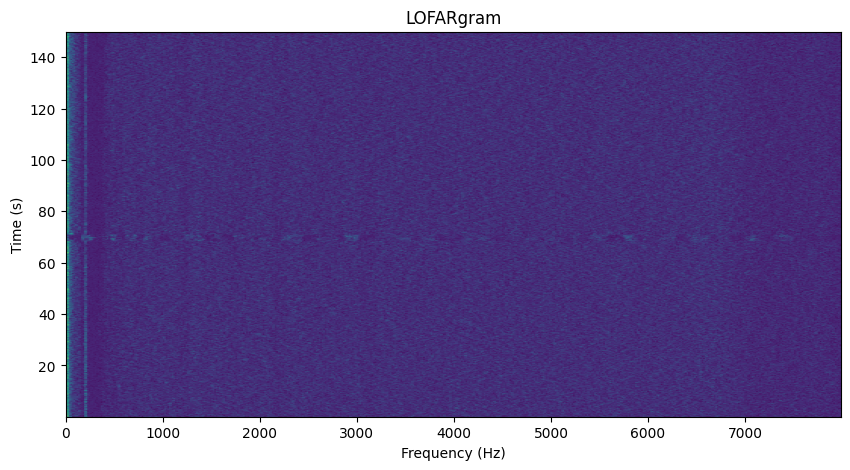

In [34]:
cls = '3'
run = 'H-1782'

sxx =  iara_spectrogram[cls][run]['sxx']
freq = iara_spectrogram[cls][run]['freq']
time = iara_spectrogram[cls][run]['time']

from poseidon.visualization import plot_lofargram
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
plot_lofargram(sxx, freq, time, ax=ax)
plt.show()

In [35]:
metadata_df = pd.read_csv(csv_path)
metadata_df['Length'] = metadata_df['Length'].apply(lambda x: np.nan if x == ' - ' else float(x))
metadata_df['Ship Length Class'] = metadata_df['Length'].apply(Target.classify_value)
metadata_df

cross_validator = SonarCrossValidator(
    metadata_df=metadata_df,
    target_column='Ship Length Class',
    stratify_columns=['Ship Length Class'],
    n_splits=config.n_splits,
    random_state=config.seed
)

train_data, test_data = cross_validator.get_fold_data(config.fold, cache_dir)

Creating 5 stratified splits based on columns: ['Ship Length Class']
Created class mapping: {0: 0, 1: 1, 2: 2, 3: 3}


In [36]:
is2d = config.window_size != 1

train_dataset = SonarRunDataset(train_data, window_size=config.window_size, overlap=config.overlap, is2d=is2d)
test_dataset = SonarRunDataset(test_data, window_size=config.window_size, overlap=config.overlap, is2d=is2d)

Building window map for SonarRunDataset...
Map built. Total windows available: 393117
Building window map for SonarRunDataset...
Map built. Total windows available: 99129


In [ ]:
from poseidon.utils import calculate_class_weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

class_weights = calculate_class_weights(train_dataset, device)

input_size = (config.window_size, config.n_freqs)
model_cl = model_select(config)
raise NotImplementedError("Model training not implemented yet.")